# 1. Introduction

In this lab, you will learn how to do stock price prediction using LSTM (don't get too happy, because there is a random component to it you cannot predict which resembles more a random walk), perform movie classification, and generate random texts.

In [1]:
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

In [2]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.8/112.8 KB 807.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 9.6 MB/s eta 0:00:00
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting un

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import yfinance as yf
import random
import tensorflow as tf
from tensorflow import keras
%matplotlib inline

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Stock Price Classification

In this first part, you will try to predict stock prices of any company. Instead of doing a prediction, you will try to classify stocks as `strong_buy`, `buy`, `neutral`, `sell`, `strong_sell`, if the price in the next day closed $>5\%$, between $1\%$ and $5\%$, within $-1\%$ and $1\%$, between $-1\%$ and $-5\%$, and more than $-5\%$, respectively.

In [4]:
stock_ticket = 'AMD'
stock = yf.download(stock_ticket, start='2021-01-01', end='2022-12-31', progress=False)
stock.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,92.110001,96.059998,90.919998,92.300003,92.300003,51802600
2021-01-05,92.099998,93.209999,91.410004,92.769997,92.769997,34208000
2021-01-06,91.620003,92.279999,89.459999,90.330002,90.330002,51911700
2021-01-07,91.330002,95.510002,91.199997,95.160004,95.160004,42897200
2021-01-08,95.980003,96.400002,93.269997,94.580002,94.580002,39816400


In [5]:
stock.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-12-23,63.110001,64.660004,62.720001,64.519997,64.519997,45923000
2022-12-27,63.869999,64.279999,62.970001,63.270000,63.270000,36086000
2022-12-28,62.540001,63.540001,61.959999,62.570000,62.570000,39526500
2022-12-29,63.639999,65.180000,63.060001,64.820000,64.820000,41428500
2022-12-30,63.770000,64.820000,63.139999,64.769997,64.769997,37127000


Let's first only consider the closing values of the stock prices.

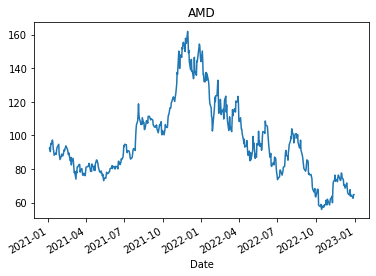

In [6]:
stock.Close.plot()
plt.title(stock_ticket)
plt.show()

In [7]:
stock_close = stock.Close

In [8]:
stock_close.head()

Date
2021-01-04    92.300003
2021-01-05    92.769997
2021-01-06    90.330002
2021-01-07    95.160004
2021-01-08    94.580002
Name: Close, dtype: float64

Now, let's consider the percent change of the next value with respect to the current value of the stock. Note that the last entry using `diff(-1)` will be `not a number`, because there is nothing to compare againt.

In [9]:
stock_next = -stock_close.diff(-1) / stock_close
stock_next.columns = ['Next']

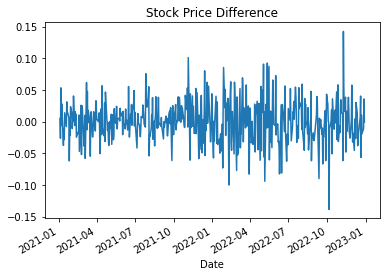

In [10]:
stock_next.plot()
plt.title('Stock Price Difference')
plt.show()

In [11]:
std = np.std(stock_next.values[:-1])
std

0.03319686575007782

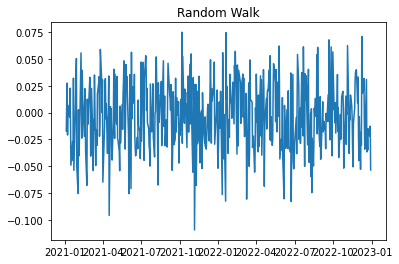

In [12]:
r = np.random.normal(0, std, size=len(stock_next[:-1]))
plt.plot(stock_next.index[:-1], r)
plt.title('Random Walk')
plt.show()

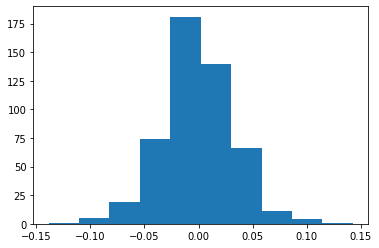

In [13]:
plt.hist(stock_next.values, bins=10)
plt.show()

In [14]:
stock_next.head()

Date
2021-01-04    0.005092
2021-01-05   -0.026302
2021-01-06    0.053471
2021-01-07   -0.006095
2021-01-08    0.028230
Name: Close, dtype: float64

In [15]:
stock_next.tail()

Date
2022-12-23   -0.019374
2022-12-27   -0.011064
2022-12-28    0.035960
2022-12-29   -0.000771
2022-12-30         NaN
Name: Close, dtype: float64

Because the last entry is `not-a-number`, let's remove the last entry and create the following class values:

- 0: strong sell
- 1: sell
- 2: neutral
- 3: buy
- 4: strong buy

In [16]:
last_date = stock_close.index[-1]
del stock_close[last_date]
del stock_next[last_date]
stock_next.tail()

Date
2022-12-22    0.010335
2022-12-23   -0.019374
2022-12-27   -0.011064
2022-12-28    0.035960
2022-12-29   -0.000771
Name: Close, dtype: float64

In [17]:
values = stock_next.values
action = np.where(
    np.abs(values) > 0.05,
    np.sign(values) * 2,
    np.where(
        np.abs(values) > 0.01,
        np.sign(values) * 1,
        0
    )
).astype(np.int32)
action

array([ 0, -1,  2,  0,  1, -1, -1, -1, -1,  1,  0,  1,  1,  1,  0, -2, -1,
       -1,  1,  1, -1,  0,  0,  1,  0,  1,  0,  1, -1, -1, -1,  1, -1,  0,
        1, -2,  1,  1, -1, -1, -1,  0, -2,  2, -1,  1,  0,  1,  0,  0, -2,
        1,  1, -1, -1,  0,  1,  0, -1,  1,  1,  0,  0,  0,  1,  0, -2,  1,
       -1,  2, -1, -1, -1,  1, -1,  1,  1,  0, -1,  0, -1, -1,  0,  0,  0,
        1, -1,  1, -1, -1,  1,  0,  0,  1,  1, -1,  0,  0,  0,  0,  1,  0,
        1, -1,  1,  0,  0, -1,  1,  0,  0, -1,  0,  2,  0, -1,  1,  0,  1,
        0,  1,  1,  1,  0,  1,  0, -1,  0,  1,  0,  0, -1, -1, -1,  0,  0,
        1,  1,  1,  0,  0,  2,  2,  1,  1,  1,  2, -2, -1, -1, -1,  1, -1,
        1, -1,  0, -1,  0,  0,  1, -1,  0,  0,  1,  0,  0,  0,  0,  0,  0,
       -1,  0,  0,  0,  0,  0,  0, -1, -1,  1,  1,  1,  0,  1, -2, -1,  1,
        0, -1,  1,  1,  1, -1,  0,  0,  1,  1,  0,  1,  0,  0,  1,  0,  1,
        0,  0,  0,  0,  1,  1,  1,  2,  0,  2,  0, -2,  1,  1,  0,  1,  0,
        1,  0, -1, -1,  2

Note that `action` is still shifted by 2 from the values obtained before, so we can just add `2` to it.

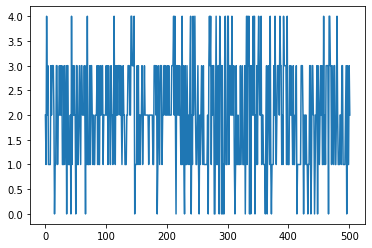

In [18]:
plt.plot(action + 2)

Let's create a training window where we can use LSTM to predict our classifier.

In [19]:
def split_data(data, action, window=1, validation_split=0.1):
    x = []
    y = []
    for i in range(window, len(data)):
        x.append(data[i-window:i])
        y.append(action[i])
        
    train_size = int((1 - validation_split) * len(x))
    
    x = np.array(x)
    y = np.array(y)
    
    return x[:train_size], y[:train_size], x[train_size:], y[train_size:]

In [20]:
data = values

data = stock_close.values
scaler = StandardScaler()
data = scaler.fit_transform(data.reshape(-1, 1)).flatten()

x_train, y_train, x_test, y_test = split_data(
    data, action + 2, window=20, validation_split=0.1)

y_train = keras.utils.to_categorical(y_train, 5)
y_test = keras.utils.to_categorical(y_test, 5)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((433, 20), (433, 5), (49, 20), (49, 5))

Now, you can create your network to try to predict wheather we should buy or sell stocks.

In [21]:
def CreateModel(i_shape, o_shape):
  x_i = keras.layers.Input(i_shape)

  x = keras.layers.Dense(64, activation='relu')(x_i)
  x = keras.layers.Dropout(0.5)(x)
  x = keras.layers.Dense(256, activation='relu')(x)
  x = keras.layers.Dropout(0.5)(x)
  x = keras.layers.Dense(128, activation='relu')(x)
  x = keras.layers.Dense(o_shape[-1], activation='softmax')(x)
  
  return keras.models.Model(x_i, x)
  
sgd = keras.optimizers.Adam(0.001)
model = CreateModel(x_train.shape[1:], y_train.shape[1:])
model.compile(
    loss='categorical_crossentropy', optimizer=sgd, metrics=['acc'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20)]              0         
                                                                 
 dense (Dense)               (None, 64)                1344      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 256)               16640     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 5)                 645   

In [22]:
history = model.fit(x_train, y_train, epochs=100, batch_size=64, 
          verbose=True, validation_data=(x_test, y_test))

Epoch 1/100
7/7 [==============================] - 6s 45ms/step - loss: 1.6212 - acc: 0.2448 - val_loss: 1.4736 - val_acc: 0.3673
Epoch 2/100
7/7 [==============================] - 0s 7ms/step - loss: 1.5489 - acc: 0.2841 - val_loss: 1.4740 - val_acc: 0.3265
Epoch 3/100
7/7 [==============================] - 0s 7ms/step - loss: 1.5140 - acc: 0.2818 - val_loss: 1.5416 - val_acc: 0.3469
Epoch 4/100
7/7 [==============================] - 0s 8ms/step - loss: 1.4719 - acc: 0.3002 - val_loss: 1.6032 - val_acc: 0.1837
Epoch 5/100
7/7 [==============================] - 0s 7ms/step - loss: 1.4826 - acc: 0.2979 - val_loss: 1.5902 - val_acc: 0.2653
Epoch 6/100
7/7 [==============================] - 0s 8ms/step - loss: 1.4888 - acc: 0.3141 - val_loss: 1.5431 - val_acc: 0.3265
Epoch 7/100
7/7 [==============================] - 0s 11ms/step - loss: 1.4945 - acc: 0.2679 - val_loss: 1.5550 - val_acc: 0.3469
Epoch 8/100
7/7 [==============================] - 0s 9ms/step - loss: 1.4749 - acc: 0.3372 - v

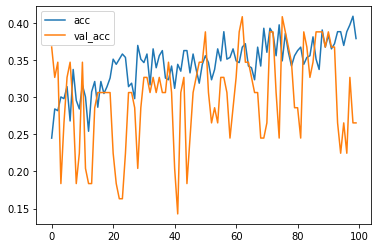

In [23]:
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [24]:
model.evaluate(x_train, y_train), model.evaluate(x_test, y_test)

2/2 [==============================] - 0s 13ms/step - loss: 1.5692 - acc: 0.2653


([1.3024343252182007, 0.40415704250335693],
 [1.5691527128219604, 0.26530611515045166])

In [25]:
p = model.predict(x_test)
print('distribution of classes:', np.sum(y_train, axis=0))
print('acc of model:', np.mean(np.argmax(y_test, axis=1) == np.argmax(p, axis=1), axis=0))
y_test_v = np.argmax(y_test, axis=1)
p_test_v = np.argmax(p, axis=1)

# we will check if at least we got the signs correctly

y_test_s = y_test_v - 2
p_test_s = p_test_v - 2

movement_right = 0

for i in range(len(y_test)):
    ok = 'nok'
    if y_test_s[i] < 0 and p_test_s[i] < 0:
        ok = '-ok'
        movement_right += 1
    elif y_test_s[i] > 0 and p_test_s[i] > 0:
        ok = '+ok'
        movement_right += 1
    elif y_test_s[i] == 0 and p_test_s[i] == 0:
        ok = '0ok'
        movement_right += 1
print('% of right movement predictions:', movement_right / len(p_test_v))
print(y_test_v)
print(p_test_v)

2/2 [==============================] - 0s 6ms/step
distribution of classes: [ 31. 120. 128. 122.  32.]
acc of model: 0.2653061224489796
% of right movement predictions: 0.2653061224489796
[3 2 3 1 1 4 1 2 1 3 3 3 3 0 4 4 3 3 1 3 2 1 3 3 1 1 2 4 2 1 1 1 2 2 1 3 3
 1 1 1 1 2 3 0 3 1 1 3 2]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 1 1 3 1 1 1 1 1 2 3 3 2 2 3 3 3
 3 2 2 2 3 3 3 2 2 2 2 2]


Not very impressive, as 30% actually means not much better than random guessing for 5 classes (20%), although we could get 47% of the movements right. Now, it is your turn to try to improve our stock prediction using LSTM's or GRUs. 

Another good datapoint is the following. In most of the cases, a good classifier needs to beat the previous day prediction as well.

In [26]:
acc_previous_day = 0
movement_right = 0

p_test_v[0] = np.argmax(y_train[-1])
p_test_v[1:] = y_test_v[0:-1]

p_test_s = p_test_v - 2

for i in range(len(y_test)):
    ok = 'nok'
    if y_test_s[i] < 0 and p_test_s[i] < 0:
        ok = '-ok'
        movement_right += 1
    elif y_test_s[i] > 0 and p_test_s[i] > 0:
        ok = '+ok'
        movement_right += 1
    elif y_test_s[i] == 0 and p_test_s[i] == 0:
        ok = '0ok'
        movement_right += 1
    acc_previous_day += (y_test_s[i] == p_test_s[i])

print('acc previous day:', acc_previous_day / len(p_test_v))
print('% of right movement predictions:', movement_right / len(p_test_v))
print(y_test_v)
print(p_test_v)

acc previous day: 0.32653061224489793
% of right movement predictions: 0.3469387755102041
[3 2 3 1 1 4 1 2 1 3 3 3 3 0 4 4 3 3 1 3 2 1 3 3 1 1 2 4 2 1 1 1 2 2 1 3 3
 1 1 1 1 2 3 0 3 1 1 3 2]
[2 3 2 3 1 1 4 1 2 1 3 3 3 3 0 4 4 3 3 1 3 2 1 3 3 1 1 2 4 2 1 1 1 2 2 1 3
 3 1 1 1 1 2 3 0 3 1 1 3]


In [47]:
def CreateModel(i_shape, o_shape):
    x_i = keras.layers.Input(i_shape)
    x = keras.layers.LSTM(50, return_sequences=True, dropout=0.5) (x_i)
    x = keras.layers.LSTM(50, dropout=0.5) (x)
    x = keras.layers.Dense(64, activation='relu')(x) 
    x = keras.layers.Dense(256, activation='relu')(x)
    x = keras.layers.Dense (128, activation='relu')(x)
    x = keras.layers.Dense(o_shape[-1], activation='softmax')(x)
    return keras.models.Model (x_i, x)



In [48]:
from keras.models import Model
from keras import activations

In [52]:
sgd = keras.optimizers.Adam(0.01)
model = CreateModel((*x_train.shape[1:], 1),y_train.shape [1:])
model.compile(
loss='categorical_crossentropy', optimizer=sgd, metrics=['acc']) 
model.summary ()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 20, 1)]           0         
                                                                 
 lstm_10 (LSTM)              (None, 20, 50)            10400     
                                                                 
 lstm_11 (LSTM)              (None, 50)                20200     
                                                                 
 dense_17 (Dense)            (None, 64)                3264      
                                                                 
 dense_18 (Dense)            (None, 256)               16640     
                                                                 
 dense_19 (Dense)            (None, 128)               32896     
                                                                 
 dense_20 (Dense)            (None, 5)                 645 

In [53]:
history = model.fit(x_train, y_train, epochs=100, batch_size=64, 
          verbose=True, validation_data=(x_test, y_test))

Epoch 1/100
7/7 [==============================] - 9s 172ms/step - loss: 1.5642 - acc: 0.2448 - val_loss: 1.4785 - val_acc: 0.3673
Epoch 2/100
7/7 [==============================] - 0s 12ms/step - loss: 1.4822 - acc: 0.2887 - val_loss: 1.4675 - val_acc: 0.1837
Epoch 3/100
7/7 [==============================] - 0s 12ms/step - loss: 1.4689 - acc: 0.2956 - val_loss: 1.4506 - val_acc: 0.3265
Epoch 4/100
7/7 [==============================] - 0s 12ms/step - loss: 1.4649 - acc: 0.2818 - val_loss: 1.4307 - val_acc: 0.3265
Epoch 5/100
7/7 [==============================] - 0s 13ms/step - loss: 1.4610 - acc: 0.2864 - val_loss: 1.4313 - val_acc: 0.2245
Epoch 6/100
7/7 [==============================] - 0s 12ms/step - loss: 1.4566 - acc: 0.2818 - val_loss: 1.4930 - val_acc: 0.1837
Epoch 7/100
7/7 [==============================] - 0s 12ms/step - loss: 1.4542 - acc: 0.3048 - val_loss: 1.4357 - val_acc: 0.3265
Epoch 8/100
7/7 [==============================] - 0s 15ms/step - loss: 1.4588 - acc: 0.2

In [62]:
def CreateModel(i_shape, o_shape):
    x_i = keras.layers.Input(i_shape)
    x = keras.layers.GRU(50, return_sequences=True, dropout=0.5) (x_i)
    x = keras.layers.GRU(50, dropout=0.5) (x)
    x = keras.layers.Dense(64, activation='relu')(x) 
    x = keras.layers.Dense(256, activation='relu')(x)
    x = keras.layers.Dense (128, activation='relu')(x)
    x = keras.layers.Dense(o_shape[-1], activation='softmax')(x)
    return keras.models.Model (x_i, x)

In [64]:
sgd = keras.optimizers.Adam(0.01)
model = CreateModel((*x_train.shape[1:], 1), y_train.shape[1:])
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['acc']) 
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 20, 1)]           0         
                                                                 
 gru_2 (GRU)                 (None, 20, 50)            7950      
                                                                 
 gru_3 (GRU)                 (None, 50)                15300     
                                                                 
 dense_22 (Dense)            (None, 64)                3264      
                                                                 
 dense_23 (Dense)            (None, 256)               16640     
                                                                 
 dense_24 (Dense)            (None, 128)               32896     
                                                                 
 dense_25 (Dense)            (None, 5)                 645 

In [68]:
import numpy as np
from tensorflow import keras

def CreateModel(i_shape, o_shape):
    x_i = keras.layers.Input(i_shape)
    x = keras.layers.GRU(50, return_sequences=True, dropout=0.5) (x_i)
    x = keras.layers.GRU(50, dropout=0.5) (x)
    x = keras.layers.Dense(64, activation='relu')(x) 
    x = keras.layers.Dense(256, activation='relu')(x)
    x = keras.layers.Dense (128, activation='relu')(x)
    x = keras.layers.Dense(o_shape[-1], activation='softmax')(x)
    return keras.models.Model (x_i, x)

# reshape input data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# create and compile the model
model = CreateModel(x_train.shape[1:], y_train.shape[1:])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train the model
history = model.fit(x_train, y_train, epochs=100, batch_size=64, verbose=True, validation_data=(x_test, y_test))


Epoch 1/100
7/7 [==============================] - 8s 183ms/step - loss: 1.5980 - accuracy: 0.2333 - val_loss: 1.5545 - val_accuracy: 0.1837
Epoch 2/100
7/7 [==============================] - 0s 23ms/step - loss: 1.5372 - accuracy: 0.2818 - val_loss: 1.4757 - val_accuracy: 0.3265
Epoch 3/100
7/7 [==============================] - 0s 26ms/step - loss: 1.4967 - accuracy: 0.2748 - val_loss: 1.5676 - val_accuracy: 0.1837
Epoch 4/100
7/7 [==============================] - 0s 46ms/step - loss: 1.4790 - accuracy: 0.2979 - val_loss: 1.5845 - val_accuracy: 0.1837
Epoch 5/100
7/7 [==============================] - 0s 34ms/step - loss: 1.4592 - accuracy: 0.2841 - val_loss: 1.5186 - val_accuracy: 0.1837
Epoch 6/100
7/7 [==============================] - 0s 22ms/step - loss: 1.4565 - accuracy: 0.2933 - val_loss: 1.4887 - val_accuracy: 0.1837
Epoch 7/100
7/7 [==============================] - 0s 23ms/step - loss: 1.4523 - accuracy: 0.2933 - val_loss: 1.5192 - val_accuracy: 0.1837
Epoch 8/100
7/7 [==

# 3. IMDB Text Classification

In this next lab, you will create a text classification using LSTMs.

In [1]:
from keras import preprocessing
from keras.datasets import imdb

In [2]:
# Load imdb dataset and print a few samples to check.
#
# IMDB: sentence (x) -> positive/negative (y)
#
# “The food was really good”                             -> pos
# “The chicken crossed the road because it was uncooked” -> neg

num_words = 10000
maxlen = 100
embedded_size = 16

In [3]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)

17464789/17464789 [==============================] - 2s 0us/step


In [4]:
d = imdb.get_word_index()
for w in d:
    if d[w] == 22:
        print(w)
        break

1641221/1641221 [==============================] - 0s 0us/step
you


In [5]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((25000,), (25000,), (25000,), (25000,))

In [6]:
x_train[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

x_train has a size (training_size, ). Because the sentences have variable size, we cannot represent this in matrix format.

The first step is to make the column size constant. We do that by "padding" the sentences. If the sentences are bigger, we clip them. If they are smaller, we insert a "NO_WORD" token to the sentence.

In [7]:
import keras

In [8]:
x_train = keras.utils.pad_sequences(x_train, maxlen=maxlen)
x_test = keras.utils.pad_sequences(x_test, maxlen=maxlen)
x_train.shape, x_test.shape

((25000, 100), (25000, 100))

In [9]:
x_train[0]

array([1415,   33,    6,   22,   12,  215,   28,   77,   52,    5,   14,
        407,   16,   82,    2,    8,    4,  107,  117, 5952,   15,  256,
          4,    2,    7, 3766,    5,  723,   36,   71,   43,  530,  476,
         26,  400,  317,   46,    7,    4,    2, 1029,   13,  104,   88,
          4,  381,   15,  297,   98,   32, 2071,   56,   26,  141,    6,
        194, 7486,   18,    4,  226,   22,   21,  134,  476,   26,  480,
          5,  144,   30, 5535,   18,   51,   36,   28,  224,   92,   25,
        104,    4,  226,   65,   16,   38, 1334,   88,   12,   16,  283,
          5,   16, 4472,  113,  103,   32,   15,   16, 5345,   19,  178,
         32], dtype=int32)

In [10]:
def CreateModel(i_shape):
    x_i = keras.layers.Input(i_shape)
    x = keras.layers.Embedding(num_words, embedded_size,
                               input_length=maxlen)(x_i)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(1, activation="sigmoid")(x)

    return keras.models.Model(x_i, x)

model = CreateModel(x_train.shape[1:])
model.summary()

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 16)           160000    
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 1)                 1601      
                                                                 
Total params: 161,601
Trainable params: 161,601
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.fit(
    x_train, y_train, epochs=20, batch_size=64,
    validation_split=0.2)

Epoch 1/20
313/313 [==============================] - 29s 79ms/step - loss: 0.6277 - acc: 0.6664 - val_loss: 0.4622 - val_acc: 0.8080
Epoch 2/20
313/313 [==============================] - 6s 20ms/step - loss: 0.3466 - acc: 0.8648 - val_loss: 0.3428 - val_acc: 0.8544
Epoch 3/20
313/313 [==============================] - 3s 10ms/step - loss: 0.2381 - acc: 0.9143 - val_loss: 0.3267 - val_acc: 0.8528
Epoch 4/20
313/313 [==============================] - 5s 15ms/step - loss: 0.1724 - acc: 0.9461 - val_loss: 0.3324 - val_acc: 0.8508
Epoch 5/20
313/313 [==============================] - 3s 10ms/step - loss: 0.1214 - acc: 0.9700 - val_loss: 0.3415 - val_acc: 0.8522
Epoch 6/20
313/313 [==============================] - 3s 9ms/step - loss: 0.0819 - acc: 0.9858 - val_loss: 0.3563 - val_acc: 0.8482
Epoch 7/20
313/313 [==============================] - 4s 11ms/step - loss: 0.0540 - acc: 0.9946 - val_loss: 0.3749 - val_acc: 0.8484
Epoch 8/20
313/313 [==============================] - 2s 8ms/step - l

**3.1 What's the current accuracy for this model?**

In [12]:
eval_result = model.evaluate(x_test, y_test)
eval_result[1]

782/782 [==============================] - 2s 3ms/step - loss: 0.5875 - acc: 0.8372


0.8371999859809875


# **3.2 Try to add a preloaded embedded from Glove from this model**

**Question: why does this model may help you get better accuracy?**
The accuracy of this model is expected to improve as the embeddings used in it have already been pre-trained to capture the relationships between words. Therefore, the final layer of the model (which is trainable) can take advantage of these relationships during training for better performance in predicting sentiment in the IMDB dataset.

In [77]:
import os
import multiprocessing

In [78]:
def analyze_imdb_sentiment2(max_sequence_len=100, embedded_size=16, weights=None):
    MAX_FEATURES = 10000
    
    if weights is None:
        weights = get_embedding_weight(embedded_size, MAX_FEATURES)
    
    (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=MAX_FEATURES)
    
    x_train = pad_sequences(x_train, maxlen=max_sequence_len)
    x_test = pad_sequences(x_test, maxlen=max_sequence_len)

    
    xi = Input(max_sequence_len)

    # Embedding input is (training_size, max_sequence_len)
    # Embedding output is (training_size, max_sequence_len, embedded_size)

    x = Embedding(MAX_FEATURES, embedded_size, input_length=max_sequence_len,
              weights=[weights], trainable=True)(xi)
    x = Conv1D(100, 5, activation='relu')(x)
    x = MaxPooling1D(5)(x)
    x = Flatten()(x)
    x = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=xi, outputs=x)

    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
    model.summary()

    history = model.fit(
            x_train, y_train, epochs=20, batch_size=32, validation_split=0.2,
            workers=(multiprocessing.cpu_count() - 1), use_multiprocessing=True)
    
    evalutation = model.evaluate(x_test, y_test)
    print(evalutation)
    return evalutation

In [79]:
def get_embedding_weight(embedded_size, max_features):
    MAX_FEATURES = 10000
    embeddings_index, embedding_pretrain_size = load_pretrained_embedding_idx(embedded_size)
    
    assert embedding_pretrain_size >= embedded_size
    
    return get_embedding_matrix(
        imdb.get_word_index(),
        embeddings_index,
        MAX_FEATURES,
        embedded_size)

In [80]:
def load_pretrained_embedding_idx(dimension):
    assert dimension in [50, 100, 200, 300]
    CURR_DIR   = os.getcwd()
    PRETRAINED = 'glove.6B.%dd.txt' % dimension
#     PRETRAINED = 'glove.42B.%dd.txt' % dimension
    
    embeddings_index = {}
    
    with open(os.path.join(CURR_DIR, PRETRAINED), "r") as fd:
        for line in fd:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        
    return embeddings_index, dimension

In [81]:
def get_embedding_matrix(word_index, embeddings_index, max_features, embedded_size):
    embedding_matrix = np.zeros((max_features, embedded_size))
    for word, i in word_index.items():
        if i >= max_features:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
            
    return embedding_matrix

In [63]:
import os


In [82]:
analyze_imdb_sentiment2(embedded_size=200)

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 100)]             0         
                                                                 
 embedding_13 (Embedding)    (None, 100, 200)          2000000   
                                                                 
 conv1d_1 (Conv1D)           (None, 96, 100)           100100    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 19, 100)          0         
 1D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 1900)              0         
                                                                 
 dense_13 (Dense)            (None, 1)                 1901      
                                                          

[1.013079047203064, 0.8348000049591064]

### **TRYING LSTM**

In [83]:
import multiprocessing
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import preprocessing
from tensorflow.keras.datasets import imdb

In [85]:
MAX_FEATURES = 10000
MAX_SEQUENCE_LEN = 100
EMBEDDED_SIZE = 16

In [86]:
# Load imdb dataset and print a few samples to check.
#
# IMDB: sentence (x) -> positive/negative (y)
#
# “The food was really good” 				 -> pos
# “The chicken crossed the road because it was uncooked” -> neg

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=MAX_FEATURES)

# x_train has a size (training_size, ). Because the sentences have variable size,
# we cannot represent this in matrix format.

print(x_train.shape)


x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=MAX_SEQUENCE_LEN)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=MAX_SEQUENCE_LEN)

#print(x_train.shape)



print(x_train[0])

# Input shape should be now (training_size, MAX_SEQUENCE_LEN)

(25000,)
(25000, 100)
[1415   33    6   22   12  215   28   77   52    5   14  407   16   82
    2    8    4  107  117 5952   15  256    4    2    7 3766    5  723
   36   71   43  530  476   26  400  317   46    7    4    2 1029   13
  104   88    4  381   15  297   98   32 2071   56   26  141    6  194
 7486   18    4  226   22   21  134  476   26  480    5  144   30 5535
   18   51   36   28  224   92   25  104    4  226   65   16   38 1334
   88   12   16  283    5   16 4472  113  103   32   15   16 5345   19
  178   32]


In [87]:
def get_embedding_weight(embedded_size, max_features):
    embeddings_index, embedding_pretrain_size = load_pretrained_embedding_idx(embedded_size)
    
    assert embedding_pretrain_size >= embedded_size
    
    return get_embedding_matrix(
        imdb.get_word_index(),
        embeddings_index,
        max_features,
        embedded_size)

In [88]:
def load_pretrained_embedding_idx(dimension):
    assert dimension in [50, 100, 200, 300]
    CURR_DIR   = os.getcwd()
    PRETRAINED = 'glove.6B.%dd.txt' % dimension

    
    embeddings_index = {}
    
    with open(os.path.join(CURR_DIR, PRETRAINED), "r") as fd:
        for line in fd:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        
    return embeddings_index, dimension

In [89]:
def get_embedding_matrix(word_index, embeddings_index, max_features, embedded_size):
    embedding_matrix = np.zeros((max_features, embedded_size))
    for word, i in word_index.items():
        if i >= max_features:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            
    return embedding_matrix

In [94]:
def analyze_imdb_sentiment_lstm(
    max_sequence_len=100,
    embedded_size=16,
    weights=None,
    use_weight=False):
    MAX_FEATURES = 10000
    
    if use_weight and weights is None:
        weights = get_embedding_weight(embedded_size, MAX_FEATURES)
    
    (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=MAX_FEATURES)
    
    x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=max_sequence_len)
    x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=max_sequence_len)

    
    xi = Input(max_sequence_len)

    if use_weight:
        x = Embedding(MAX_FEATURES, embedded_size, input_length=max_sequence_len,
              weights=[weights])(xi)
    else:
        x = Embedding(MAX_FEATURES, embedded_size, input_length=max_sequence_len)(xi)

    x = Conv1D(300, 5, activation='relu')(x)
    x = MaxPooling1D(5)(x)

    x = SpatialDropout1D(0.4)(x)

    x = LSTM(280, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(x)
    x = LSTM(160, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(x)
    x = LSTM(50, dropout=0.2, recurrent_dropout=0.2)(x)

    x = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=xi, outputs=x)

    optimizer = Adam(learning_rate=0.0008, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["acc"])
    model.summary()

    history = model.fit(
            x_train, y_train, epochs=5, batch_size=16, validation_split=0.2,
            workers=(multiprocessing.cpu_count() - 1), use_multiprocessing=True)

    evalutation = model.evaluate(x_test, y_test,
                                 workers=(multiprocessing.cpu_count() - 1),
                                 use_multiprocessing=True)
    print(evalutation)
    return evalutation

In [95]:
def train_combination():
    MAX_FEATURES = 10000

    result = []
    for embedded_size in [16, 32, 50, 100, 200, 300]:
        for max_sequence_len in [50, 100, 200, 300]:
            _, accuracy = analyze_imdb_sentiment_lstm(max_sequence_len, embedded_size)
            result.append((embedded_size, max_sequence_len, accuracy))
            
    return result

In [ ]:
res = train_combination()



Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 50)]              0         
                                                                 
 embedding_15 (Embedding)    (None, 50, 16)            160000    
                                                                 
 conv1d_3 (Conv1D)           (None, 46, 300)           24300     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 9, 300)           0         
 1D)                                                             
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 9, 300)           0         
 lDropout1D)                                                     
                                                                 
 lstm_12 (LSTM)              (None, 9, 280)            650

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 100)]             0         
                                                                 
 embedding_16 (Embedding)    (None, 100, 16)           160000    
                                                                 
 conv1d_4 (Conv1D)           (None, 96, 300)           24300     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 19, 300)          0         
 1D)                                                             
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 19, 300)          0         
 lDropout1D)                                                     
                                                                 
 lstm_15 (LSTM)              (None, 19, 280)           650

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 200)]             0         
                                                                 
 embedding_17 (Embedding)    (None, 200, 16)           160000    
                                                                 
 conv1d_5 (Conv1D)           (None, 196, 300)          24300     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 39, 300)          0         
 1D)                                                             
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 39, 300)          0         
 lDropout1D)                                                     
                                                                 
 lstm_18 (LSTM)              (None, 39, 280)           650

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 300)]             0         
                                                                 
 embedding_18 (Embedding)    (None, 300, 16)           160000    
                                                                 
 conv1d_6 (Conv1D)           (None, 296, 300)          24300     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 59, 300)          0         
 1D)                                                             
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 59, 300)          0         
 lDropout1D)                                                     
                                                                 
 lstm_21 (LSTM)              (None, 59, 280)           650

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 50)]              0         
                                                                 
 embedding_19 (Embedding)    (None, 50, 32)            320000    
                                                                 
 conv1d_7 (Conv1D)           (None, 46, 300)           48300     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 9, 300)           0         
 1D)                                                             
                                                                 
 spatial_dropout1d_5 (Spatia  (None, 9, 300)           0         
 lDropout1D)                                                     
                                                                 
 lstm_24 (LSTM)              (None, 9, 280)            650

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 100)]             0         
                                                                 
 embedding_20 (Embedding)    (None, 100, 32)           320000    
                                                                 
 conv1d_8 (Conv1D)           (None, 96, 300)           48300     
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 19, 300)          0         
 1D)                                                             
                                                                 
 spatial_dropout1d_6 (Spatia  (None, 19, 300)          0         
 lDropout1D)                                                     
                                                                 
 lstm_27 (LSTM)              (None, 19, 280)           650

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 200)]             0         
                                                                 
 embedding_21 (Embedding)    (None, 200, 32)           320000    
                                                                 
 conv1d_9 (Conv1D)           (None, 196, 300)          48300     
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 39, 300)          0         
 1D)                                                             
                                                                 
 spatial_dropout1d_7 (Spatia  (None, 39, 300)          0         
 lDropout1D)                                                     
                                                                 
 lstm_30 (LSTM)              (None, 39, 280)           650

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 300)]             0         
                                                                 
 embedding_22 (Embedding)    (None, 300, 32)           320000    
                                                                 
 conv1d_10 (Conv1D)          (None, 296, 300)          48300     
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 59, 300)          0         
 g1D)                                                            
                                                                 
 spatial_dropout1d_8 (Spatia  (None, 59, 300)          0         
 lDropout1D)                                                     
                                                                 
 lstm_33 (LSTM)              (None, 59, 280)           650

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 50)]              0         
                                                                 
 embedding_23 (Embedding)    (None, 50, 50)            500000    
                                                                 
 conv1d_11 (Conv1D)          (None, 46, 300)           75300     
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 9, 300)           0         
 g1D)                                                            
                                                                 
 spatial_dropout1d_9 (Spatia  (None, 9, 300)           0         
 lDropout1D)                                                     
                                                                 
 lstm_36 (LSTM)              (None, 9, 280)            650

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 100)]             0         
                                                                 
 embedding_24 (Embedding)    (None, 100, 50)           500000    
                                                                 
 conv1d_12 (Conv1D)          (None, 96, 300)           75300     
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 19, 300)          0         
 g1D)                                                            
                                                                 
 spatial_dropout1d_10 (Spati  (None, 19, 300)          0         
 alDropout1D)                                                    
                                                                 
 lstm_39 (LSTM)              (None, 19, 280)           650

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 200)]             0         
                                                                 
 embedding_25 (Embedding)    (None, 200, 50)           500000    
                                                                 
 conv1d_13 (Conv1D)          (None, 196, 300)          75300     
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 39, 300)          0         
 g1D)                                                            
                                                                 
 spatial_dropout1d_11 (Spati  (None, 39, 300)          0         
 alDropout1D)                                                    
                                                                 
 lstm_42 (LSTM)              (None, 39, 280)           650

Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 300)]             0         
                                                                 
 embedding_26 (Embedding)    (None, 300, 50)           500000    
                                                                 
 conv1d_14 (Conv1D)          (None, 296, 300)          75300     
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 59, 300)          0         
 g1D)                                                            
                                                                 
 spatial_dropout1d_12 (Spati  (None, 59, 300)          0         
 alDropout1D)                                                    
                                                                 
 lstm_45 (LSTM)              (None, 59, 280)           650

Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 50)]              0         
                                                                 
 embedding_27 (Embedding)    (None, 50, 100)           1000000   
                                                                 
 conv1d_15 (Conv1D)          (None, 46, 300)           150300    
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 9, 300)           0         
 g1D)                                                            
                                                                 
 spatial_dropout1d_13 (Spati  (None, 9, 300)           0         
 alDropout1D)                                                    
                                                                 
 lstm_48 (LSTM)              (None, 9, 280)            650

Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 100)]             0         
                                                                 
 embedding_28 (Embedding)    (None, 100, 100)          1000000   
                                                                 
 conv1d_16 (Conv1D)          (None, 96, 300)           150300    
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 19, 300)          0         
 g1D)                                                            
                                                                 
 spatial_dropout1d_14 (Spati  (None, 19, 300)          0         
 alDropout1D)                                                    
                                                                 
 lstm_51 (LSTM)              (None, 19, 280)           650

Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 200)]             0         
                                                                 
 embedding_29 (Embedding)    (None, 200, 100)          1000000   
                                                                 
 conv1d_17 (Conv1D)          (None, 196, 300)          150300    
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 39, 300)          0         
 g1D)                                                            
                                                                 
 spatial_dropout1d_15 (Spati  (None, 39, 300)          0         
 alDropout1D)                                                    
                                                                 
 lstm_54 (LSTM)              (None, 39, 280)           650

# 4. Generate Text from Nietzsche's Writings

In this example, you will generate text from Nietzsche's writings.

At least 20 epochs are required before the generated text
starts sounding coherent.

It is recommended to run this script on GPU, as recurrent
networks are quite computationally intensive.

If you try this script on new data, make sure your corpus
has at least ~100k characters. ~1M is better.

In [54]:
path = keras.utils.get_file("nietzsche.txt",
        origin="https://s3.amazonaws.com/text-datasets/nietzsche.txt")

text = open(path).read().lower()
print("corpus length:", len(text))

600901/600901 [==============================] - 0s 1us/step
corpus length: 600893


In [55]:
chars = set(text)
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

total chars: 57


In [56]:
# cut the text in semi-redundant sequences of maxlen characters
maxlen = 100
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print("nb sequences:", len(sentences))

nb sequences: 200265


In [57]:
print("Vectorization...")
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Vectorization...


<ipython-input-57-7564032e437b>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
<ipython-input-57-7564032e437b>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = np.zeros((len(sentences), len(chars)), dtype=np.bool)


In [58]:
# build the model: 2 stacked LSTM
print("Build model...")
xi = keras.layers.Input((maxlen, len(chars)))
x = keras.layers.GRU(256, return_sequences=True)(xi)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.GRU(256, return_sequences=False)(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(len(chars))(x)
x = keras.layers.Activation("softmax")(x)

model = keras.models.Model(inputs=xi, outputs=x)
model.summary()

Build model...
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 100, 57)]         0         
                                                                 
 gru (GRU)                   (None, 100, 256)          241920    
                                                                 
 dropout_2 (Dropout)         (None, 100, 256)          0         
                                                                 
 gru_1 (GRU)                 (None, 256)               394752    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_21 (Dense)            (None, 57)                14649     
                                                                 
 activation (Activation)     (None, 57)     

In [59]:
adam = keras.optimizers.Adam(0.003)

model.compile(loss="categorical_crossentropy", optimizer=adam)

In [60]:
def sample(a, temperature=1.0):
    # helper function to sample an index from a probability array
    a = (np.log(a + 1e-8) / temperature).astype(np.float64)
    a = np.exp(a) / np.sum(np.exp(a))
    try:
      sample_result = np.argmax(np.random.multinomial(1, a, 1))
    except ValueError:
      error = 1.0 - np.sum(a)
      a[0] += error
      sample_result = np.argmax(np.random.multinomial(1, a, 1))
    return sample_result

In [61]:
import sys

# train the model, output generated text after each iteration
for iteration in range(1, 60):
    print()
    print("-" * 50)
    print("Iteration", iteration)

    model.fit(X, y, batch_size=4096, epochs=4)
    model.save_weights("weights.hdf5")

    start_index = random.randint(0, len(text) - maxlen - 1)

    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print()
        print("----- diversity:", diversity)

        generated = ""
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print("----- Generating with seed: '" + sentence + "'")
        sys.stdout.write(generated)

        for i in range(200):
            x = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x[0, t, char_indices[char]] = 1.

            # predict next char
            preds = model.predict(x, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            # full sentence being generated
            generated += next_char

            # shift sentence
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
            
            # let's consider only one sentence
            if next_char == ".":
              break
        print()


--------------------------------------------------
Iteration 1
Epoch 1/4
 8/49 [===>..........................] - ETA: 22s - loss: 3.4402

KeyboardInterrupt: ignored

- Pick up one set of data samples from linux kernel source code (https://github.com/torvalds/linux)
- Modify the model to be trained in the corpus
- Present the results